<a href="https://colab.research.google.com/github/SharifNirjon/customer-churn/blob/modeling_customer_churn/modeling_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
)

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

!pip install optuna
import optuna

from imblearn.over_sampling import SMOTE

import joblib
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.2 MB/s eta 0:00:00


In [4]:
df_save_path='/content/processed_telco_churn.csv'
df=pd.read_csv(df_save_path)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two years,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket,churn_label
0,Female,0,No,No,-0.307022,No,No,-2.807879,-0.330903,True,...,True,False,True,True,False,False,True,False,0,0
1,Female,0,No,No,3.861085,Yes,Yes,-5.321187,-0.309476,False,...,False,True,False,False,True,False,False,False,4,0
2,Male,0,Yes,Yes,0.526599,Yes,Yes,-1.271261,-0.291377,False,...,True,False,True,True,False,False,False,True,1,0
3,Female,0,Yes,Yes,3.861085,Yes,Yes,-0.100505,-0.121118,False,...,True,False,True,True,False,True,False,False,4,0
4,Female,0,Yes,Yes,-0.376491,No,Yes,-4.783530,-0.343480,True,...,False,False,False,False,False,False,True,False,0,0


In [5]:
#target is churn_label
X=df.drop("churn_label", axis=1)
y=df["churn_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
model_features_path=Path.cwd()/'models'/'model_features.pkl'
model_features_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(X_train.columns.tolist(), model_features_path)

['/content/models/model_features.pkl']

initializing XGBoost


In [7]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    device="cuda",
    random_state=42
)

In [8]:
print(xgb.enable_categorical)

False


In [11]:
xgb.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:gender: object, Partner: object, Dependents: object, PhoneService: object, PaperlessBilling: object

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# ============================================
# FIX:  ENCODE ALL CATEGORICAL VARIABLES
# ============================================
print("="*80)
print("🔧 ENCODING CATEGORICAL VARIABLES FOR XGBOOST")
print("="*80)

# Check current data types
print("\n📊 Current Data Types:")
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"   Object columns found: {len(object_cols)}")
for col in object_cols:
    print(f"   • {col}:  {X_train[col].unique()[:5]}")

# Binary categorical columns (Yes/No, Male/Female)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# Method 1: Map binary columns to 0/1
print("\n🔄 Encoding binary columns...")
for col in binary_cols:
    if col in X_train.columns:
        unique_vals = X_train[col].unique()
        print(f"   {col}: {unique_vals}")

        if len(unique_vals) == 2:
            # Binary encoding
            if 'Yes' in unique_vals or 'No' in unique_vals:
                X_train[col] = X_train[col].map({'No': 0, 'Yes':  1})
                X_test[col] = X_test[col].map({'No': 0, 'Yes': 1})
            elif 'Male' in unique_vals or 'Female' in unique_vals:
                X_train[col] = X_train[col].map({'Female': 0, 'Male':  1})
                X_test[col] = X_test[col].map({'Female': 0, 'Male': 1})

            print(f"   ✅ {col} encoded to:  {X_train[col].unique()}")

# Verify all columns are now numeric
print("\n✅ Verification:")
remaining_objects = X_train.select_dtypes(include=['object']).columns.tolist()
if len(remaining_objects) == 0:
    print("   All columns are now numeric!")
else:
    print(f"   ⚠️ Still have object columns: {remaining_objects}")

print(f"\n📊 Final Data Types:")
print(X_train.dtypes. value_counts())

# Now train XGBoost
print("\n🚀 Training XGBoost...")
xgb. fit(X_train, y_train)
print("✅ Training complete!")

🔧 ENCODING CATEGORICAL VARIABLES FOR XGBOOST

📊 Current Data Types:
   Object columns found: 5
   • gender:  ['Male' 'Female']
   • Partner:  ['Yes' 'No']
   • Dependents:  ['Yes' 'No']
   • PhoneService:  ['Yes' 'No']
   • PaperlessBilling:  ['Yes' 'No']

🔄 Encoding binary columns...
   gender: ['Male' 'Female']
   ✅ gender encoded to:  [1 0]
   Partner: ['Yes' 'No']
   ✅ Partner encoded to:  [1 0]
   Dependents: ['Yes' 'No']
   ✅ Dependents encoded to:  [1 0]
   PhoneService: ['Yes' 'No']
   ✅ PhoneService encoded to:  [1 0]
   PaperlessBilling: ['Yes' 'No']
   ✅ PaperlessBilling encoded to:  [1 0]

✅ Verification:
   All columns are now numeric!

📊 Final Data Types:
bool       21
int64       7
float64     3
Name: count, dtype: int64

🚀 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Training complete!


In [13]:
xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
y_pred=xgb.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [18:24:16] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [15]:
y_proba = xgb.predict_proba(X_test)[:, 1]

In [16]:
def objective(trial):
    param={
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'use_label_encoder':False,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2),
        'random_state': 42,
        'use_label_encoder': False,
        'device': "cuda"
    }

    model=XGBClassifier(**param)

    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores=cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial: ")
trial=study.best_trial
print(trial.params)

[I 2026-01-15 18:24:23,990] A new study created in memory with name: no-name-b06e2d7f-ee93-4bab-9a6f-adb18f17f2b9
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-15 18:24:24,903] Trial 0 finished with value: 0.9717755813126644 and parameters: {'learning_rate': 0.12181767598524088, 'max_depth': 10, 'n_estimators': 213, 'subsample': 0.9642716364706151, 'colsampl

Best trial: 
{'learning_rate': 0.035750445192011045, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.9923960031663909, 'colsample_bytree': 0.5059730270131048, 'gamma': 0.20882369854081836, 'reg_alpha': 0.010193088277070203, 'reg_lambda': 1.1976673629432582}


In [17]:
xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:25:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

accuracy=accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
roc_auc=roc_auc_score(y_test, y_proba)

print(f"Accuracy; {accuracy: .4f}")
print(f"F1-score; {f1: .4f}")
print(f"ROC-AUC; {roc_auc: .4f}")
print("\nClassification Report: \n", classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy;  0.9636
F1-score;  0.9792
ROC-AUC;  0.9763

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85        57
           1       0.97      0.98      0.98       382

    accuracy                           0.96       439
   macro avg       0.93      0.90      0.92       439
weighted avg       0.96      0.96      0.96       439



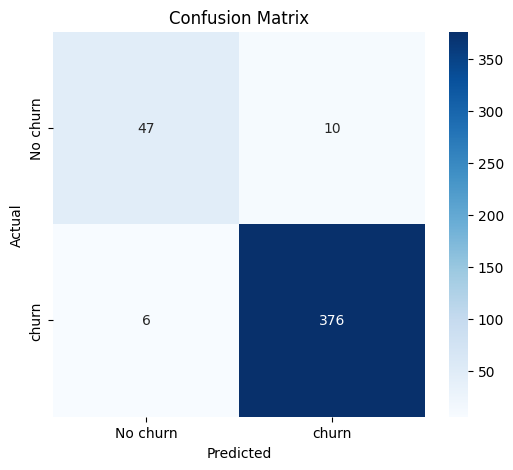

In [19]:
cm=confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=['No churn', 'churn'], yticklabels=['No churn', 'churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
smote = SMOTE(sampling_strategy=0.73, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [21]:
def objective(trial):
    param={
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'use_label_encoder':False,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2),
        'random_state': 42,
        'use_label_encoder': False,
        'device': "cuda"
    }

    model=XGBClassifier(**param)

    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores=cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')
    return scores.mean()

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial: ")
trial=study.best_trial
print(trial.params)

[I 2026-01-15 18:32:09,676] A new study created in memory with name: no-name-e6ee9538-e0e8-479d-b438-fa9ff8029eb4
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-15 18:32:11,655] Trial 0 finished with value: 0.9573513584232382 and parameters: {'learning_rate': 0.011870611934474636, 'max_depth': 5, 'n_estimators': 321, 'subsample': 0.7181042247533995, 'colsampl

Best trial: 
{'learning_rate': 0.20180231923810266, 'max_depth': 7, 'n_estimators': 411, 'subsample': 0.591458040515333, 'colsample_bytree': 0.7839469780840844, 'gamma': 0.014372117259898842, 'reg_alpha': 0.14473341203307835, 'reg_lambda': 0.8036679836400707}


In [22]:
# 2. Train XGBoost on resampled data
xgb_smote = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    learning_rate=0.09423988353764122,
    max_depth=4,
    n_estimators=227,
    subsample=0.7510280011101731,
    colsample_bytree= 0.7645977574980288,
    gamma=1.3386893470230095,
    reg_alpha=0.954715000010483,
    reg_lambda=0.9214847598660335,
    device="cuda",
    random_state=42,
)

xgb_smote.fit(X_train_resampled, y_train_resampled)

# 3. Predict on the original test set
y_pred_smote = xgb_smote.predict(X_test)
y_proba_smote = xgb_smote.predict_proba(X_test)[:, 1]

# 4. Evaluate
print("Accuracy; ", round(accuracy_score(y_test, y_pred_smote), 4))
print("F1-score; ", round(f1_score(y_test, y_pred_smote), 4))
print("ROC-AUC; ", round(roc_auc_score(y_test, y_proba_smote), 4))

print("\nClassification Report: ")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:40:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy;  0.9613
F1-score;  0.9779
ROC-AUC;  0.9722

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        57
           1       0.97      0.98      0.98       382

    accuracy                           0.96       439
   macro avg       0.93      0.90      0.92       439
weighted avg       0.96      0.96      0.96       439

